# Intro Scalable Deep Learning: Day 2, Tutorial 1
# Deep Learning Basics Recap

**Content creators**: Roshni Kamath, Jenia Jitsev

**Content reviewers / testers**: Helmholtz AI Team

**Content supervisors** : Jenia Jitsev

---
# Tutorial Objectives

In this tutorial, we'll revise some fundamental machine learning and deep learning basics. Many of these basic topics will remain important for going to larger scale with distributed training.

We will refresh basics on
- train test split, train test error
- data normalization
- optimization via gradient descent
- learning rate / batch size

We will have hands on with:
* MNIST, CIFAR-10 datasets
* Simple fully connected and convolutional networks
* Finding proper learning rate and batch size for training procedure

The goal is to get reminded what is important for a basic training procedure when dealing with deep neural networks.

This tutorial will take up about 1 hour to complete

## Exercises Overview 

#### Exercise 1: Repairing a broken training

#### Exercise 2: Influence of learning rate 

#### Exercise 3: Tune a convolutional network

#### Exercise 4: Influence of a batch size



---
# Setup

In [3]:
# --- Here, setup routines only: imports, general settings valid for all code to follow
%matplotlib inline 

# importing basic libraries and tools
import numpy as np

import tensorflow as tf
# enables eager execution for TF 1.x (TF 2 has it as default)
# tf.enable_eager_execution()
# disable eager mode for TF 2
# tf.compat.v1.disable_eager_execution()

from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D


from tensorflow.keras.datasets import mnist
from sklearn.datasets import load_digits
from tensorflow.keras.utils import to_categorical

# display figures in the notebook
import matplotlib.pyplot as plt
import argparse
import seaborn as sns

import utils.cifar10 as cifar10

SEED_NUM = 16823
np.random.seed(SEED_NUM)  # for reproducibility 

PATH_MNIST = '/p/project/training2306/datasets/MNIST/mnist.npz'
PATH_CIFAR10 = '/p/project/training2306/datasets/cifar10'


2022-03-09 12:46:10.252007: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


## Exercise 1: Repair a broken training

#### Reminder: Train test (and validation) split

We use the training set to train the network: in supervised setting, training loss is computed following forward pass by comparing the network's output $\hat{\mathbf{Y}}$ given inputs $\mathbf{X}$ from training set $\mathcal{D}^{tr}$ against the ground truth (training set $\mathcal{D}^{tr}$ labels $\mathbf{Y}$). In the backward pass, training loss gradient $\dfrac{\partial \mathcal{L}}{\partial \mathbf{W}}$ with respect to the weights $\mathbf{W}$ is computed using automatic differentiation. Weight updates are computed using the gradients and network is updated towards reducing the training loss.

We have to use a separate test set $\mathcal{D}^{ts}$, $\mathcal{D}^{tr} \cap \mathcal{D}^{tr} = \emptyset$  to get a proper estimation of how well our network might do on new data that it has never seen before. This is sometimes also referred to as generalization error estimate. If a network performs well on the training set $\mathcal{D}^{tr}$, but poorly on the test set $\mathcal{D}^{ts}$, then we have a generalization gap - the network has overfit to the training set.

If we in addition tune hyperparamers of the training procedure, like for instance learning rate or batch size, we **have to create validation** split $\mathcal{D}^{val}$ in addition to be able to report final test generalization error estimate on a separate test set $\mathcal{D}^{ts}$ after performing model hyperparameter based selection on validation set $\mathcal{D}^{val}$.

### Let's load MNIST digits data

MNIST dataset can be considered as Drosophila or "Hello, World" of machine learning. It is dated back to 80-90s (predecessor was NIST which MNIST is subset of). It is still used for first test runs to check basic sanity of the training. It has following structure: 
- 70k samples of grayscale hand written digits
- 28x28 input resolution

Standard train and test split is in 60k and 10k large subsets. (A part of train can be then further split into a validation set)  

In [2]:
# Load data 

# a helper function to load from a local file
def load_MNIST(path):

    with np.load(path, allow_pickle=True) as f:
        X_train_MNIST, Y_train_MNIST = f['x_train'], f['y_train']
        X_test_MNIST, Y_test_MNIST = f['x_test'], f['y_test']

    return (X_train_MNIST, Y_train_MNIST), (X_test_MNIST, Y_test_MNIST)


(X_train_MNIST, Y_train_MNIST), (X_test_MNIST, Y_test_MNIST) = load_MNIST(PATH_MNIST)

In [3]:
print("Input Data shape (MNIST): ", X_train_MNIST.shape)

Input Data shape (MNIST):  (60000, 28, 28)


### Explore the loaded data
It is always a good practice to visualize samples from the data and check its structure, dimensions and values involved.

Below we define help methods to plot data structure

In [5]:
def plot_data(X, y):
   
    _, axes = plt.subplots(ncols=5, nrows=3, figsize=(12, 9))

    for i, ax in enumerate(axes.ravel()):
        ax.imshow((X[i]),cmap=plt.cm.gray_r, interpolation='nearest')
        ax.set_title("training label: %d"% y[i])
        
def plot_label_distribution(data):
    unique_train, counts_train = np.unique(data, return_counts=True)

    _, ax0 = plt.subplots(ncols=1, sharex=True, figsize=(15, 6))

    ax0.bar(unique_train, counts_train, color='darkgreen')
    ax0.set_xticks(unique_train)
    ax0.set_xlabel("Label")
    ax0.set_ylabel("Quantity")
    ax0.set_title("Labels in MNIST training dataset")


### Task 1.1:
1. Display the inputs images from the training and test set.
    - Think about what values will enter the network at the input?
2. Plot the label distribution and class balance in the training set. (Hint: Use np.unique)
    - What can be said about balance within the training, within the test set?

In [ ]:
# TODO: Plot a selection of the input images using plot_data method above

In [ ]:
# TODO: Plot the label distribution 

### Now that we have inspected the MNIST dataset, let's prepare the data for training a digit recognition model

In [8]:
train_samples = X_train_MNIST.shape[0]
test_samples = X_test_MNIST.shape[0]

input_height = X_train_MNIST.shape[1]
input_width = X_train_MNIST.shape[2]
input_channel = 1


In [9]:
# flatten for input to a fully connected dense network
x_train_MNIST = X_train_MNIST.reshape(train_samples, input_height * input_width, input_channel)
x_test_MNIST = X_test_MNIST.reshape(test_samples, input_height * input_width, input_channel)

# Convert labels to categorical data (0 ... 1 .... 0), one-hot - to provide proper form to compute loss
y_train_MNIST = to_categorical(Y_train_MNIST)
y_test_MNIST = to_categorical(Y_test_MNIST)

In [94]:
print("Input shape flat:", x_train_MNIST.shape[1])
print("Label shape (one-hot):", y_train_MNIST.shape[1])

print("Labels one-hot examples: \n", y_train_MNIST[0:2])


Input shape train data original: (28, 28)
Input shape flat: 784
Label shape (one-hot): 10
Labels one-hot examples: 
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


Max value train:  255
Min value train:  0
Mean value train:  33.318421449829934
Std value train:  78.56748998339798
Input sample label :  2


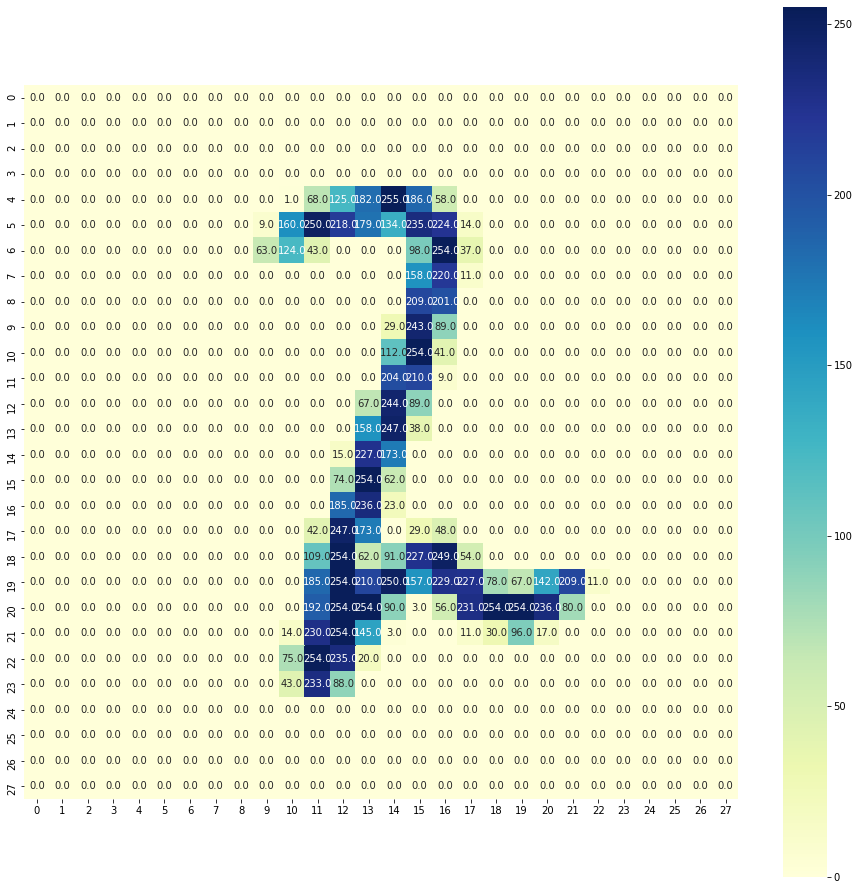

In [10]:
# look at an input sample

max_value = x_train_MNIST.max()
min_value = x_train_MNIST.min()

mean_value = x_train_MNIST.mean()
std_value = x_train_MNIST.std()

print("Max value train: ", max_value)
print("Min value train: ", min_value)

print("Mean value train: ", mean_value)
print("Std value train: ", std_value)

# Index number of an instance (change this to view another instance).
sample_index = 674
fig_size = 16

image = (X_train_MNIST[sample_index]).reshape(input_height, input_width)
label = Y_train_MNIST[sample_index]

print("Input sample label : ", label)
f, ax = plt.subplots(figsize=(fig_size, fig_size))
sns.heatmap(image, annot=True, fmt='.1f', square=True, cmap="YlGnBu")
plt.show()

#### Considerations
Here we have one sample of many that network will see during the training 
- Think about what values will enter the network at the input?

### Task 1.2:

1. The `mnist_fit_FCNet_model` function defined below trains a fully connected model on raw **MNIST** data. The function returns a `history` object that holds a record of the loss values and metric values during training. the `plot_accuracy` fucntion uses this `history` object to plot the training/validation loss and accuracy curves. Employ method `plot_accuracy` to plot the training/validation statistics of the **FCNet** model. 

In [2]:
def plot_accuracy(history):
    import pandas as pd

    fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(12, 6))
    history_df = pd.DataFrame(history.history)
    history_df["epoch"] = history.epoch

    # For TF 1.x 'acc' and 'val_acc'
    history_df.plot(x="epoch", y=["loss", "val_loss"], ax=ax0)
    history_df.plot(x="epoch", y=["accuracy", "val_accuracy"], ax=ax1);

    

In [1]:
def mnist_fit_FCNet_model(learning_rate, epochs=5,batch_size=32, nesterov=False, momentum=0.0):

    # Load data and preprocess
    (X_train_MNIST, Y_train_MNIST), (X_test_MNIST, Y_test_MNIST) = load_MNIST(PATH_MNIST) 
    # load MNIST data

    input_channels = 1

    # dataset properties
    train_samples = X_train_MNIST.shape[0]
    test_samples = X_test_MNIST.shape[0]
    input_height = X_train_MNIST.shape[1]
    input_width = X_train_MNIST.shape[2]

    # flatten images for input to a fully connected dense network
    X_train = X_train_MNIST.reshape(train_samples, input_height * input_width, input_channels)
    X_test = X_test_MNIST.reshape(test_samples, input_height * input_width, input_channels)

    # Convert training labels to categorical data (0 ... 1 .... 0), one-hot - to provide proper form to compute loss
    Y_train = to_categorical(Y_train_MNIST)
    # Test labels for trained model testing on the test set
    Y_test = Y_test_MNIST

    input_dim = X_train.shape[1]
    
    # Shape of input to the network: spatial dimensions (here 1 dim flat vector), and channels number 
    # (e.g 3 for RGB, here 1)
    input_shape = (input_dim, input_channels)

    hidden_dim = 128
    output_dim = 10
    activation_func = 'relu' # sigmoid, tanh, relu, elu, ...

    # Define a set for validation: 5000 out of 60000 - 55000 train, 5000 validation
    validation_split = 1/12 

    # -------- Network Barebone Description, Functional Keras API --------------

    inputs = Input(shape = (input_dim, ))
    x = Dense(hidden_dim, activation = activation_func, input_shape = input_shape)(inputs)
    output = Dense(output_dim, activation='softmax')(x)

    # -------- Compile network model  --------------
    model = Model(inputs, output)
    
    optimizer=optimizers.SGD(learning_rate=learning_rate, nesterov=nesterov, momentum=momentum)    

    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # print out network description
    model.summary()

    history = model.fit(X_train, Y_train, validation_split=validation_split, epochs=epochs, batch_size=batch_size)

    return history 

In [ ]:
# Employ the use of `mnist_fit_FCNet_model` and `plot_accuracy` to plot the training/validation curves.
# TODO: Run this cell! 
history = mnist_fit_FCNet_model(learning_rate = 0.01, epochs=10,batch_size=32, nesterov=False)
plot_accuracy(history)

### Considerations
Observe the training process 
- What is the behavior of the training / validation loss / accuracy across the epochs?
- Can you think of the reasons what is happening during the training?
- Can you think of what may have cause the issue and how it can be fixed?

### Reminder: Data Normalization

Data normalization (e.g., rescaling of the input, zero mean and unit variance transformation) is usually required for proper optimization during training. Without normalization, basic numerical issues with large activations, large loss magnitudes and large gradient amplitudes will cause training procedure to fail. Another reason can be for instance the necessity to deal with input values that may have very different scales. For example, normalizing when we have input values such as 0.1 vs 200 is necessary. Different inputs may have different magnitudes and this difference may be high. Think about an absolute value of a single input, if it is high, it can cause high activations in the network that may cause instabilities when computing loss and its gradients.  Think about difference in absolute values between different input entries. This may lead to large inputs dominating over small ones without any good reason which can severerly impair learning.

Let us apply standard rescaling to normalize the data

### Task 1.2: Applying normalization transform to the data
- Find a way to rescale the original data to a form suitable for input to the network
    - Should we compute the normalizing factor over training or test set to normalize test data? Why?

In [11]:
# compute scaling factor for train : use the maximum value

max_value = x_train_MNIST.max()
min_value = x_train_MNIST.min()

mean_value = x_train_MNIST.mean()
std_value = x_train_MNIST.std()

print("Max value train: ", max_value)
print("Min value train: ", min_value)

print("Mean value train: ", mean_value)
print("Std value train: ", std_value)

rescaling_max = max_value

# --- rescale input
x_train_MNIST_scaled = x_train_MNIST.astype('float32') / rescaling_max  # Normalize between 0 and 1
# ! USE ON TEST only TRAIN normalizing factors !
# Otherwise considered as sneaking information from train to test
x_test_MNIST_scaled = x_test_MNIST.astype('float32') / rescaling_max

Max value train:  255
Min value train:  0
Mean value train:  33.318421449829934
Std value train:  78.56748998339798


In [ ]:
# Index number of an instance (change this to view another instance).
sample_index = 674
fig_size = 12

image = (x_train_MNIST_scaled[sample_index]).reshape(input_height, input_width)
label = y_train_MNIST[sample_index]

f, ax = plt.subplots(figsize=(fig_size, fig_size))
sns.heatmap(image, annot=True, fmt='.1f', square=True, cmap="YlGnBu")
plt.show()

#### Considerations
Here we have one sample of many that network will see during the training 
- Think about what values will enter the network at the input?

#### Let's train the network on normalized data 

In [31]:
# find the mean of the training input data
mean_train = x_train_MNIST_scaled.mean()
# find the std of the training input data
std_train = x_train_MNIST_scaled.std()

# Recall: Why do we apply train normalization factors to test data?
x_train_MNIST_meanfree = (x_train_MNIST_scaled - mean_train)/std_train
x_test_MNIST_meanfree = (x_test_MNIST_scaled - mean_train)/std_train

# Plot the one of the sample input and notice the change in the values
# Index number of an instance (change this to view another instance).
sample_index = 674
fig_size = 12

image = (x_train_MNIST_meanfree[sample_index]).reshape(input_height, input_width)
label = y_train_MNIST[sample_index]

f, ax = plt.subplots(figsize=(fig_size, fig_size))
sns.heatmap(image, annot=True, fmt='.1f', square=True, cmap="YlGnBu")
plt.show()

In [12]:
def mnist_fit_FCNet_model(learning_rate=0.01, epochs=5, batch_size=32, nesterov=False, momentum=0.0):

    (X_train_MNIST, Y_train_MNIST), (X_test_MNIST, Y_test_MNIST) = load_MNIST(PATH_MNIST) # load MNIST data

    # dataset properties
    train_samples = X_train_MNIST.shape[0]
    test_samples = X_test_MNIST.shape[0]
    input_height = X_train_MNIST.shape[1]
    input_width = X_train_MNIST.shape[2]

    # one channel only for MNIST input to the network
    input_channels = 1

    print("Labels in the original data:", Y_train_MNIST[0:10])

    # flatten images for input to a fully connected dense network
    X_train = X_train_MNIST.reshape(train_samples, input_height * input_width, input_channels)
    X_test = X_test_MNIST.reshape(test_samples, input_height * input_width, input_channels)

    # Convert training labels to categorical data (0 ... 1 .... 0), one-hot - to provide proper form to compute loss
    Y_train = to_categorical(Y_train_MNIST)
    # Test labels for trained model testing on the test set
    Y_test = Y_test_MNIST

    # --- INFO print
    print("Input shape train data original:", X_train_MNIST.shape[1:3])
    print("Input shape flat:", X_train.shape[1])
    print("Label shape (one-hot):", Y_train.shape[1])
    print("Labels one-hot examples: \n", Y_train[0:2])

    # --- properties of network input and output format
    input_dims = X_train.shape[1]
    num_classes = Y_train.shape[1]
    print("Number of classes: ", num_classes)


    # --- Preprocessing and normalizing input

    # --- compute training set stats

    max_value = X_train.max()
    min_value = X_train.min()

    mean_value = X_train.mean()
    std_value = X_train.std()

    print("Max value train: ", max_value)
    print("Min value train: ", min_value)

    print("Mean value train: ", mean_value)
    print("Std value train: ", std_value)

    # --- applying scaling factor for train and test
    rescaling_max = max_value

    # --- rescale input
    X_train = X_train.astype('float32') / rescaling_max  # Normalize between 0 and 1
    # ! USE ON TEST only TRAIN normalizing factors !
    # Otherwise considered as sneaking information from train to test
    X_test = X_test.astype('float32') / rescaling_max


    # ---- zero mean, unit variance

    mean_train = X_train.mean()
    std_train = X_train.std()
    X_train = (X_train - mean_train)/(std_train + 0.1)
    # -- transforming test using scaling parameters from X_train - trainings set !!!
    X_test = (X_test - mean_train)/(std_train + 0.1)

    SEED_NUM = 16823
    np.random.seed(SEED_NUM)  # for reproducibility

    # Shape of input to the network: spatial dimensions (here 1 dim flat vector), and channels number
    # (e.g 3 for RGB, here 1)
    input_shape = (input_dims, input_channels)

    hidden_dim = 128
    output_dim = 10
    activation_func = 'relu' # sigmoid, tanh, relu, elu, ...

    validation_split = 1/12 # 5000 out of 60000; 55000 train, 5000 validation

    # -------- Network Barebone Description, Functional Keras API --------------

    inputs = Input(shape = (input_dims, ))
    x = Dense(hidden_dim, activation = activation_func, input_shape = input_shape)(inputs)
    output = Dense(output_dim, activation='softmax')(x)

    # -------- Compile network model  --------------
    model = Model(inputs, output)

    optimizer=optimizers.SGD(learning_rate=learning_rate, nesterov=nesterov, momentum=momentum)    
        

    model.compile(optimizer,
                  loss='categorical_crossentropy', metrics=['accuracy'])

    # print out network description
    model.summary()

    history = model.fit(X_train, Y_train, validation_split=validation_split, epochs=epochs, batch_size=batch_size)

    return history 


In [ ]:
# train the FC-Net model on normalized dataset and plot accuracy
# TODO: Run the cell
history = mnist_fit_FCNet_model(learning_rate=0.1, epochs = 10, batch_size=512)
plot_accuracy(history)

#### Considerations:
- Did you notice any changes in the performance?
- What would you consider to change to get training performance even better?

## Exercise 2 : Influence of learning rate

### Reminder: Learning Rate

This important training hyperparameter (often termed as $\eta$ or $\alpha$ in weight update equations) determines the step size of each network model update iteration while moving along gradient toward a smaller value of a loss function. Proper setting of learning rate is crucial for optimization procedure. In a novel domain that was not extensively used before, finding a proper learning rate can be a time and resource consuming step.

When the learning rate is too low the model training may progress very slowly and training loss can stall and remain plateaued. When the learning rate becomes just large enough by tuning it up, loss starts to decrease faster and you may find a sudden dip in the training loss plot corresponding to the faster loss decrease. The minima of the curve composed of different loss values reached during a number of steps in the initial training phase is what you are looking for when picking a good learning rate to run training with (have a look on one example of a learning rate finding routine [here : LRFinder](https://github.com/WittmannF/LRFinder)) When the learning rate becomes too high, the loss may explode, visible in a sudden jump in the training loss curve. The loss value may turn to `nan` if this growth becomes too strong, collapsing training entirely.

### Task 2.1
In this section we will tune learning rate to achieve stable training. 
We have used the built-in stochastic gradient descent (SGD) as the optimizer for the **FC-Net** model and compiled the model using standard categorical cross-entropy loss for classification, adding accuracy as the metric to report.

1. Train the **FC-Net** model for different settings of learning rate - plug your favorite values in. Plot the training/validation accuracy curves to compare the performances of different configurations.
    - What do typical behavior do you observe for very low or very high values? Why may it be? What would be the way to diagnose the cause?
    - What seems to be a reasonable range to pick learning rate from?
    - Deciding for a learning rate, what performance metric do you use?
    - How would you proceed to pick one learning rate for the given dataset and the network? How would you report the expected generalization error given this selected hyperparameter value? What would be a valid way to do so?

In [6]:
def plot_effect_of_learning_rate(learning_rates=[1E-0, 1E-2, 1E-4], nesterov=False, momentum=0.0):

    plt.figure(figsize=(18, 15))
    # create learning curves for different learning rates
    for i in range(len(learning_rates)):
        # determine the plot number
        plot_no = 420 + (i+1)
        plt.subplot(plot_no)
        # TODO: train the model and plot learning curves for a learning rate
        history = ...
        # plot learning curves
        plt.plot(history.history['accuracy'], label='train')
        plt.plot(history.history['val_accuracy'], label='validation')
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.title('Learning Rate='+str(learning_rates[i]), pad=-50)
    # show learning curves
    plt.show()

In [ ]:
# TODO: plug in your favorite learning rates
learning_rates = ....
plot_effect_of_learning_rate(learning_rates)

## Exercise 3: Tuning a convolutional network on CIFAR-10 dataset.

In this exercise, we will take another golden standard dataset, **CIFAR-10**, and train **a fully connected network** (**FCNet**)  to see how it may handle more realistic inputs. We will then switch to a more elaborate **convolutional neural network** model(**ConvNet**) and examine how it performs on CIFAR-10 compared to FCNet  

### Load CIFAR-10 data

In [4]:
(x_train_cifar10, y_train_cifar10), (x_test_cifar10, y_test_cifar10) = cifar10.load_data(PATH_CIFAR10)

In [5]:
print("x_train_cifar10.shape =", x_train_cifar10.shape, "y_train.shape =", y_train_cifar10.shape)
print("x_test_cifar10.shape =", x_test_cifar10.shape, "y_test.shape =", y_test_cifar10.shape)

x_train_cifar10.shape = (50000, 32, 32, 3) y_train.shape = (50000, 1)
x_test_cifar10.shape = (10000, 32, 32, 3) y_test.shape = (10000, 1)


In [63]:
NUM_CLASSES = 10
CIFAR10_CLASSES = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

### Explore CIFAR-10 dataset

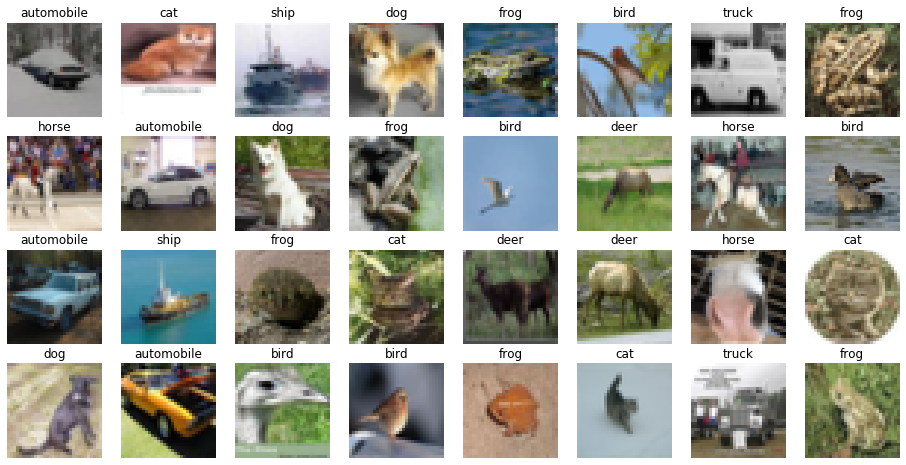

In [37]:
# show random images from training set
cols = 8 # Number of columns
rows = 4 # Number of rows

fig = plt.figure(figsize=(2 * cols, 2 * rows))

# Add subplot for each random image
for col in range(cols):
    for row in range(rows):
        random_index = np.random.randint(0, len(y_train_cifar10)) # Pick a random index for sampling the image
        ax = fig.add_subplot(rows, cols, col * rows + row + 1) # Add a sub-plot at (row, col)
        ax.grid(b=False) # Get rid of the grids
        ax.axis("off") # Get rid of the axis
        ax.imshow(x_train_cifar10[random_index, :]) # Show random image
        ax.set_title(CIFAR10_CLASSES[y_train_cifar10[random_index][0]]) # Set title of the sub-plot
plt.show() # Show the image

### Prepare data for training

In [45]:
x_train_cifar10_unflatten = x_train_cifar10.reshape((len(x_train_cifar10), 32, 32, 3))
x_test_cifar10_unflatten = x_test_cifar10.reshape((len(x_test_cifar10), 32, 32, 3))

# dataset properties
train_samples = x_train_cifar10_unflatten.shape[0]
test_samples = x_test_cifar10_unflatten.shape[0]
input_height = x_train_cifar10_unflatten.shape[1]
input_width = x_train_cifar10_unflatten.shape[2]

# for CIFAR10, 3 channels input to the netwoek
input_channels = x_train_cifar10_unflatten.shape[3]

# flatten images for input to a fully connected dense network
x_train_cifar10 = x_train_cifar10_unflatten.reshape(
    train_samples, input_height * input_width * input_channels)
x_test_cifar10 = x_test_cifar10_unflatten.reshape(
    test_samples, input_height * input_width * input_channels)

# Convert training labels to categorical data (0 ... 1 .... 0), one-hot - to provide proper form to compute loss
y_train_cifar10 = to_categorical(y_train_cifar10)
y_test_cifar10 = to_categorical(y_test_cifar10)


### Task 3.1:

1. We will now use all the above steps and use a FCNet model to train on the CIFAR-10 dataset. 
    - Plot the training/validaton curves to visualize the convergence using the `plot_accuracy` function.
    - How does the performance compare with what you saw on MNIST? 
    - The number of samples and classes is the same in MNIST and CIFAR-10, resolution only slightly higher. Is there any reason for the performance to be different?


In [12]:
def cifar10_fit_FCNet_model(learning_rate=0.01, batch_size=32, nesterov=False, momentum=0.0):

    # Load data and preprocess
    (X_train, Y_train), (X_test, Y_test) =  cifar10.load_data(PATH_CIFAR10)


    # dataset properties
    train_samples = X_train_CIFAR10.shape[0]
    test_samples = X_test_CIFAR10.shape[0]
    input_height = X_train_CIFAR10.shape[1]
    input_width = X_train_CIFAR10.shape[2]

    # three channels only for CIFAR10 as an input to the network (RGB)
    input_channels = 3
    
    # --- properties of network input and output format
    input_dims = X_train.shape[1]
    num_classes = Y_train.shape[1]
    

    # --- Preprocessing and normalizing input

    # --- compute training set stats

    max_value = X_train.max()
    min_value = X_train.min()

    mean_value = X_train.mean()
    std_value = X_train.std()

    # --- applying scaling factor for train and test
    rescaling_max = max_value

    # --- rescale input
    # Normalize between 0 and 1
    X_train = X_train.astype('float32') / rescaling_max
    # ! USE ON TEST only TRAIN normalizing factors !
    # Otherwise considered as sneaking information from train to test
    X_test = X_test.astype('float32') / rescaling_max

    # ---- zero mean, unit variance

    mean_train = X_train.mean()
    std_train = X_train.std()
    X_train = (X_train - mean_train)/(std_train + 0.1)
    # -- transforming test using scaling parameters from X_train - trainings set !!!
    X_test = (X_test - mean_train)/(std_train + 0.1)
    
    SEED_NUM = 16823
    np.random.seed(SEED_NUM)  # for reproducibility

    # Shape of input to the network: spatial dimensions (here 1 dim flat vector), and channels number
    # (e.g 3 for RGB, here 1)
    input_shape = (input_dims, input_channels)

    hidden_dim = 256  # 128, 256, 512, ...
    output_dim = num_classes
    activation_func = 'relu'  # sigmoid, tanh, relu, elu, ...
    num_layers = 3

    # ---- learning rate:
    learning_rate = learning_rate

    # ---- size of the mini batch
    batch_size = batch_size  # 32; 128; 256

    # Number of epochs: one epoch is going through the whole dataset
    epochs = 5

    # part of training dataset to be used for validation
    validation_split = 1/12  # 5000 out of 60000; 55000 train, 5000 validation

    # -------- Network Barebone Description, Functional Keras API --------------

    initializer = tf.keras.initializers.GlorotNormal()
 
    # --- Building Network using Functional API ---

    # prepare input placeholder
    inputs = Input(shape=(input_dims, ))

    x = Dense(hidden_dim, activation=activation_func,
              kernel_initializer=initializer, input_shape=input_shape)(inputs)

    layer_count = 1
    for i in range(num_layers):
        print("Adding layer: ", layer_count)
        layer_count = layer_count + 1
        x = Dense(hidden_dim, activation=activation_func,
                  kernel_initializer=initializer)(x)

    output = Dense(output_dim, activation='softmax')(x)

    # -------- Compile network model  --------------
    model = Model(inputs, output)
    
    
    optimizer=optimizers.SGD(learning_rate=learning_rate, nesterov=nesterov, momentum=momentum)
        

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # print out network description
    model.summary()

    # perform training
    history = model.fit(X_train, Y_train, validation_split=validation_split,
                        epochs=epochs, batch_size=batch_size)
    
    return history 

In [3]:
def plot_accuracy(history):
    import pandas as pd

    fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(12, 6))
    history_df = pd.DataFrame(history.history)
    history_df["epoch"] = history.epoch

    # For TF 1.x 'acc' and 'val_acc'
    history_df.plot(x="epoch", y=["loss", "val_loss"], ax=ax0)
    history_df.plot(x="epoch", y=["accuracy", "val_accuracy"], ax=ax1)

    plt.show()


In [ ]:
# TODO: plot the performance

#### Reminder: Convolutions as inductive bias and regularization
A fully connected layer offers learning from all possible combinations of the inputs of the previous layer. There are many possible patterns to be extracted from interactions among the inputs, and a fully connected layer do not make any prior assumptions about particular structure of how the inputs may interact.

**ConvNet** architectures make the explicit assumption that the inputs are images, which allows us to encode certain properties into the architecture - most importantly about strong local correlations in the input. This is often termed as building an **inductive bias** into the learning procedure, or seen as a type of regularization. A simple ConvNet is a sequence of layers, and every layer of a ConvNet transforms one volume of activations to another through a differentiable function. Three main types of layers are used to build ConvNet architectures: Convolutional Layer, Pooling Layer, and Fully-Connected Layer. We stack these layers to form a full ConvNet architecture.

<img src="conv.gif" width="750" align="center">

### CIFAR-10 with ConvNet
So let's jump into the code and run some experiments with a convolutional architecture on the CIFAR images. 

### Task 3.2:
1. Train the Convolutional Model for CIFAR-10 using a suitable learning rate and batch size. 
Compare the performance of **FCNet** with **ConvNet** by visualizing the training/validation loss and accuracy curves for both the runs together in order to compare them.
     - Compare the model summary of both **FCNet** and **ConvNet**. What are striking differences?
     - Find a good combination of learning rate and batch size for training ConvNet. Evaluate the performance by plotting the training/validation loss. 

In [4]:
def cifar10_fit_ConvNet_model(learning_rate, batch_size, nesterov=False, momentum=0.0):
    
    # Load data and preprocess
    (X_train, Y_train), (X_test, Y_test) = cifar10.load_data(PATH_CIFAR10)

    # three channels only for CIFAR10 as an input to the network (RGB)
    input_channels = 3

    # --- properties of network input and output format
    input_dims = X_train.shape[1]
    num_classes = Y_train.shape[1]

    # --- Preprocessing and normalizing input

    # --- compute training set stats

    max_value = X_train.max()
    min_value = X_train.min()

    mean_value = X_train.mean()
    std_value = X_train.std()

    # --- applying scaling factor for train and test
    rescaling_max = max_value

    # --- rescale input
    # Normalize between 0 and 1
    X_train = X_train.astype('float32') / rescaling_max
    # ! USE ON TEST only TRAIN normalizing factors !
    # Otherwise considered as sneaking information from train to test
    X_test = X_test.astype('float32') / rescaling_max

    # ---- zero mean, unit variance

    # mean = 0 ; standard deviation = 1.0

    mean_train = X_train.mean()
    std_train = X_train.std()
    X_train = (X_train - mean_train)/(std_train + 0.1)
    # -- transforming test using scaling parameters from X_train - trainings set !!!
    X_test = (X_test - mean_train)/(std_train + 0.1)

    
    SEED_NUM = 16823
    np.random.seed(SEED_NUM)  # for reproducibility

    kernel_size = 3

    # number of feature/filter maps to be used in the layers
    # num_maps = [2]
    # num_maps = [2, 4]
    # num_maps = [4, 8, 16]
    # num_maps = [16, 32, 64]
    num_maps = [16, 32, 64, 128]
    num_layers = len(num_maps) - 1


    # --- properties of network input and output format
    # input_dims = 784
    num_classes = 10

    # Shape of input to the network: spatial dimensions (here 1 dim flat vector), and channels number
    # (e.g 3 for RGB, here 1)
    # input_shape = (input_dims, input_channels)
    validation_split = 1/12

    output_dim = num_classes
    activation_func = 'relu'  # sigmoid, tanh, relu, elu, ...

    # ---- learning rate:
    # sets the step size for each weight update executed by gradient descent
    # this will determine the stability and speed of convergence during learning
    # learning rate too low - very slow convergence, can stall learning entirely
    # learning rate too high - instable, may diverge so that learning collapses entirely
    learning_rate = learning_rate

    # ---- size of the mini batch
    # too small: computationally inefficient, no advantage through vectorization; slower convergence via high noise
    # too high: lack of noise, stochasticity in updates; danger of convergence to bad (flat) local minima
    batch_size = batch_size  # 32; 128; 256

    # Number of epochs: one epoch is going through the whole dataset
    epochs = 5

    # part of training dataset to be used for validation
    # validation_split = 1/12 # 5000 out of 60000; 55000 train, 5000 validation

    # experiment with weight initialization only with deeper networks;
    # The deeper the network, the less stable training without proper weight init

    # -------- Network Barebone Description, Functional Keras API --------------

    # --- Different weight initializers for the conv layers
    initializer = tf.keras.initializers.HeUniform()
    # initializer = tf.keras.initializers.GlorotNormal()
    # initializer = tf.keras.initializers.VarianceScaling(scale=1., mode='fan_in', distribution='normal')
    # initializer = tf.keras.initializers.LecunNormal() # e.g for using with SELU

    # --- Building Convolutional Network using Functional API ---

    # CIFAR10 input dimensions : width, height, channels
    # input_dim = (32, 32, 3) # CIFAR10: 32;
    # here we are not required to provide image dimensions,
    # as we work with fully convolutional network that does not use Flatten + Dense Layer operation
    # Size of the input image can be therefore variable, which is indicated with "None"
    input_dim = (None, None, 3)

    # three channels as an input to the network (RGB)
    input_channels = 3

    # -------- define Conv Net Model Architecture --------------
    # prepare input placeholder
    input_shape = input_dim
    inputs = Input(shape=input_dim)

   
    layer_count = 0
    x = Conv2D(filters=num_maps[layer_count], kernel_size=kernel_size, activation=activation_func,
               padding='same', kernel_initializer=initializer, input_shape=input_shape)(inputs)
    x = Conv2D(filters=num_maps[layer_count], kernel_size=kernel_size,
               activation=activation_func, padding='same', kernel_initializer=initializer)(x)

    layer_count = 1
    for i in range(num_layers):
        print("Adding block: ", layer_count)
        x = Conv2D(filters=num_maps[layer_count], kernel_size=kernel_size, strides=2,
                   activation=activation_func, padding='same', kernel_initializer=initializer)(x)

        x = Conv2D(filters=num_maps[layer_count], kernel_size=kernel_size,
                   activation=activation_func, padding='same', kernel_initializer=initializer)(x)

        layer_count = layer_count + 1

    x = Conv2D(filters=10, kernel_size=(1, 1), activation=activation_func,
               padding='same', kernel_initializer=initializer)(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax')(x)

    # -------- Compile network model  --------------
    model = Model(inputs, output)

    optimizer=optimizers.SGD(learning_rate=learning_rate, nesterov=nesterov, momentum=momentum)
    model.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # print out network description
    model.summary()

    # perform training
    history = model.fit(X_train, Y_train, validation_split=validation_split, epochs=epochs, batch_size=batch_size)
    
    return history 


In [ ]:
#train the model using cifar10_fit_ConvNet_model and plot the accuracy. Compare the performance with FCNet model.
#TODO: Run this cell!
history = cifar10_fit_ConvNet_model(learning_rate=0.1, batch_size=32)
plot_accuracy(history)

### Task 3.3 - Bonus for the quick! 
##### Momentum Dynamics
SGD with Momentum performs update steps using an additional variable instead of plain gradient. This additional variable - the momentum - can be considered as velocity providing inertia to the update dynamics, accumulating information about direction and amplitude of previously computed gradients to be taken into account when performing an update step. This can help to better guide optimization, assist escaping from difficult regions of loss landscape like for instance saddles points or narrow ravines, and accelerate the training process.

1. Modify `cifar10_fit_ConvNet_model` to train with SGD using momentum. Plot the training/validation accuracy  see whether the performance improves or not. What do you observe?

In [ ]:
# train the model using cifar10_fit_ConvNet_model with nesterov=True, setting momentum=0.9, 0.95, ... and plot the accuracy 
#TODO: Run the cell!
history = cifar10_fit_ConvNet_model(learning_rate=0.1, batch_size=512, nesterov=True, momentum=0.9)
plot_accuracy(history)

#### Considerations:
- Think what may help training to get better when performance you observe is not good enough

## Exercise 4: Experiment with batch sizes

## Batching

Using mini-batches of size $\vert B \vert = n$ allows computation of loss gradients of a bunch of inputs instead of single one and utilizes compute power of GPU via vectorization. $\vert B \vert$ is a hyperparameter of training, same way as learning rate is, so choosing it will not only change input throughput during the training, but willl influence optimization trajectory and ultimately learning outcome - training loss, test loss and generalization. In following, we would like to have a short refreshing glance on what happens when batch sizes are varied.


In [6]:
def plot_effect_of_batch_sizes_loss(batch_sizes):

    _, ax = plt.subplots(1, 2, figsize=(20, 5))
    for batch_size in batch_sizes:
        
        history = cifar10_fit_ConvNet_model(learning_rate=0.1, batch_size=batch_size).history
        ax[0].plot(history['loss'], label='batch_{}'.format(batch_size))
        ax[1].plot(history['val_loss'], label='batch_{}'.format(batch_size))
        
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Training loss')
    ax[0].set_title('Training loss for different batch sizes')
    ax[0].legend()

    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Validation loss')
    ax[1].set_title('Validation loss for different batch sizes')
    ax[1].legend()

def plot_effect_of_batch_sizes_acc(batch_sizes):

    _, ax = plt.subplots(1, 2, figsize=(20, 5))
    for batch_size in batch_sizes:
        
        history = cifar10_fit_ConvNet_model(learning_rate=0.1, batch_size=batch_size).history
        ax[0].plot(history['accuracy'], label='batch_{}'.format(batch_size))
        ax[1].plot(history['val_accuracy'], label='batch_{}'.format(batch_size))
        
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Training accuracy')
    ax[0].set_title('Training accuracy for different batch sizes')
    ax[0].legend()

    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Validation accuracy')
    ax[1].set_title('Validation accuracy for different batch sizes')
    ax[1].legend()

In [7]:
def plot_effect_of_batch_sizes_acc(batch_sizes):

    _, ax = plt.subplots(1, 2, figsize=(20, 5))
    for batch_size in batch_sizes:
        
        history = cifar10_fit_ConvNet_model(learning_rate=0.1, batch_size=batch_size).history
        ax[0].plot(history['accuracy'], label='batch_{}'.format(batch_size))
        ax[1].plot(history['val_accuracy'], label='batch_{}'.format(batch_size))
        
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Training accuracy')
    ax[0].set_title('Training accuracy for different batch sizes')
    ax[0].legend()

    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Validation accuracy')
    ax[1].set_title('Validation accuracy for different batch sizes')
    ax[1].legend()

### Task 4.1:
1. Train the **ConvNet** model on different batch sizes ranging from **1 to 256**. Plot the training/validation curves using the `plot_effect_of_batch_sizes`.
    - Investigate how the accuracy of the model and the training speed is affected with small and large batch sizes. 
    - Is there any particular tendency for increasing or decreasy training / validation accuracy with varying batch size?
    - What can be done to improve the accuracy performace of the model for a particular batch size? 

In [ ]:
# TODO: define a list of batch_sizes
batch_sizes = [..]
plot_effect_of_batch_sizes_...(batch_sizes)

Reminder: To choose between different models on basis of the hyperparameters, always use a separate validation set. Split the data into three **necessarily** disjoint set, one set for training our model weights, one set to decide between different model versions having distinct hyperparameter values, and then a final part to properly estimate the generalization error of the selected model. Validation split reassures proper measurement of the generalization capability of the model - we may otherwise overfit during hyperparameter tuning without noticing it. 


### Summary:
If you made it here - be reminded that it was just a basic recap. There is much more intricacies to training deep learning network and we have explored only a bit to refresh your mind and hope you had fun along the way! 